# Visualization Tutorial

The purpose of the tutorial is to demonstrate interactive visualization with solvation_analysis and [nglview](https://github.com/nglviewer/nglview). NGLview creates interactive widgets that can be manipulated in Jupyter notebooks. You are encouraged to set up NGLview locally so that you can explore this yourself. For those who can't, static images of the output will also be shown.

In [1]:
# imports
import MDAnalysis as mda
from solvation_analysis.solute import Solute
from solvation_analysis.tests import datafiles

from IPython.display import Image

# instantiate Universe
u = mda.Universe(datafiles.ea_fec_pdb, datafiles.ea_fec_dcd)

The setup here should be familiar. We define all of our atom groups of interest and use them to instantiate a solution. EC and EMC have similar compositions, so we select them by slicing the array of residues.

In [2]:
# define solute AtomGroup
li_atoms = u.atoms.select_atoms("element Li")

# define solvent AtomGroups
EA = u.residues[0:235].atoms                    # ethyl acetate
FEC = u.residues[235:600].atoms                 # fluorinated ethylene carbonate
PF6 = u.atoms.select_atoms("byres element P")   # hexafluorophosphate

# instantiate solution
solute = Solute.from_atoms(li_atoms,
                    {'EA': EA, 'FEC': FEC, 'PF6': PF6}, 
                    radii={'PF6': 2.6, 'FEC': 2.7})

solute.run()

## Primer on Nglview

nglview is a powerful interactive molecular visualization package. Unfortunately, it can be a bit of hassle to get working properly. Make sure you have ipywidgets installed before working with nglview.

For more information on nglview, check out [their website](http://nglviewer.org/nglview/latest/) or the [MDAnalysis nglview tutorial](https://www.mdanalysis.org/2016/03/14/nglview/).

The cell below provides a test case for your Jupyter notebook configuration. If everything is configured properly, the cell will print a rectangle with "Hello, World" printed inside. If your Jupyter environment is configured incorrectly, it will instead print `Text(value='Hello, World')`.

In [3]:
# import nglview
import nglview as nv

# test Jupyter configuration
from ipywidgets import Text
Text("Hello, World")

Text(value='Hello, World')

## Visualizing the Trajectory

Now the exciting part, visualizing! We will start with a simple visualization of all atoms.

First, we call `nv.show_mdanalysis()` on an `AtomGroup` to instantiate an mda_view, which contains a persistent view of an MDA `AtomGroup`. Next, we call `mda_view.display()` to visualize our trajectory below the cell.

In [4]:
mda_view = nv.show_mdanalysis(u.atoms)
mda_view.display()

NGLWidget(max_frame=9)

This is what you should see:

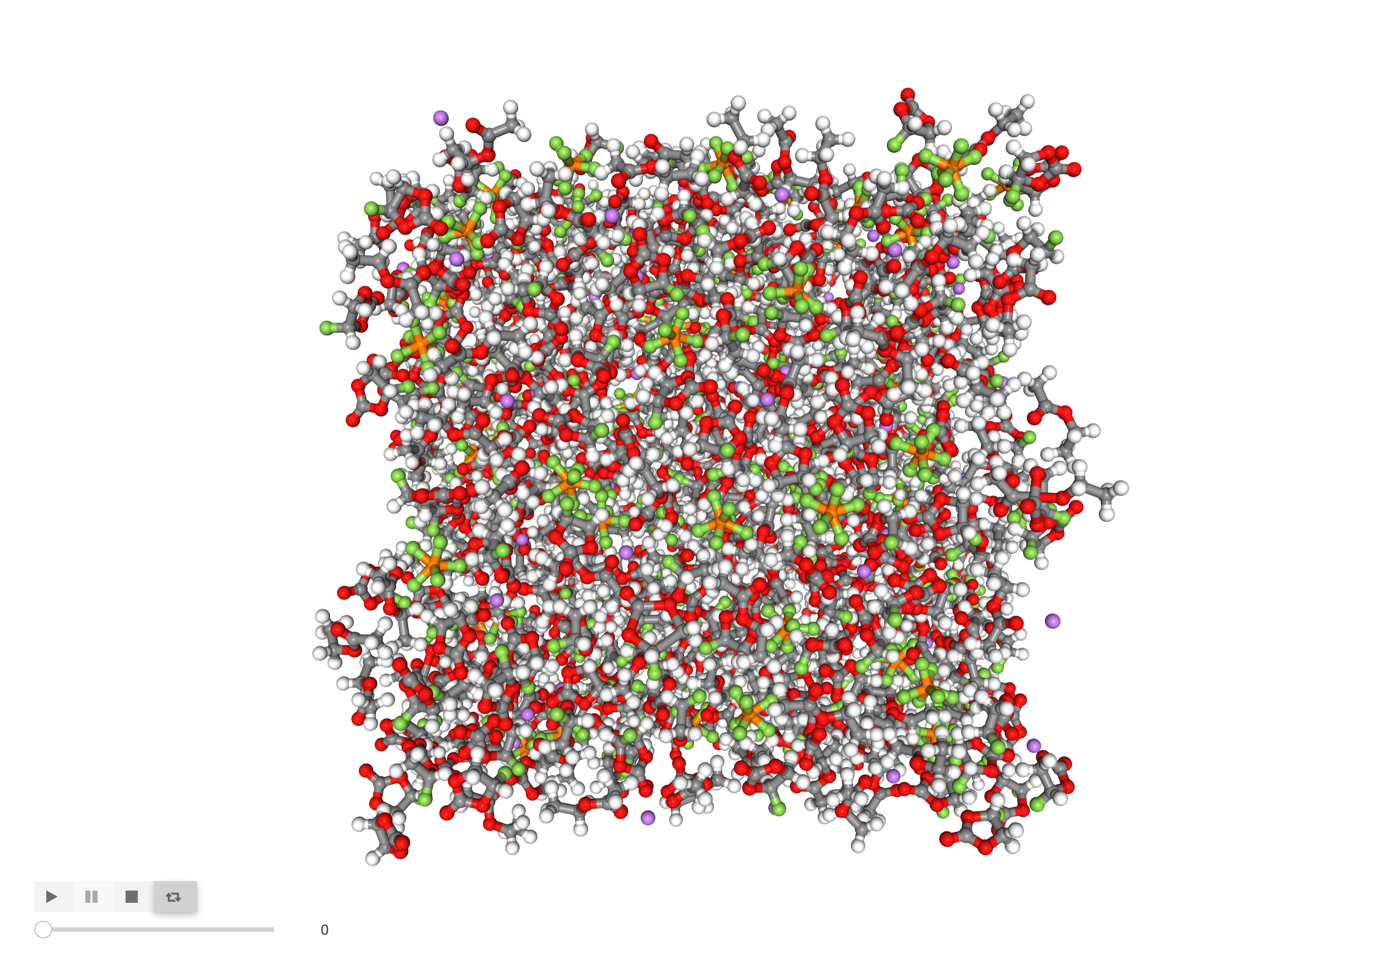

In [5]:
Image('images/all_atoms.png', width=600)

For convenience, I recommend wrapping this into a one-liner function, shown below. This is how we will use `nglview` for the remainder of the tutorial.

In [6]:
def visualize(atom_group):
    mda_view = nv.show_mdanalysis(atom_group)
    return mda_view.display()

## Interactive visualization

To kick off the interactive visualization workflow, we need to find something we are interested in visualizing! Let's see which atoms EA, FEC, and PF6<sub>6</sub><sup>-</sup> tend to coordinate with. We will start with EA.

First lets see which EA solvation shell composition is most common.

In [7]:
# return the percentage of each shell
solute.speciation.speciation_fraction.head()

,EA,FEC,PF6,count
0,3,1,0,0.252459
1,2,3,0,0.173770
2,2,2,0,0.132787
3,1,3,0,0.086885
4,4,0,0,0.059016


Looks like 3 EA and 1 FEC is the most common shell. Let's find one to visualize!

In [8]:
# find all shells with 3 EA, 1 FEC, and 0 PF6
solute.speciation.find_shells({'EA': 3, 'FEC': 1, 'PF6': 0}).head()

solvent          EA  FEC  PF6
frame solute_ix              
0     603         3    1    0
      610         3    1    0
      616         3    1    0
      620         3    1    0
      621         3    1    0

Let's go with the top, solute 603 in the frame 0. We'll save the AtomGroup as `shell`. Just to be safe we'll print the shell DataFrame to make sure we have the right composition.

In [9]:
# save the AtomGroup
shell = solute.solvation_shell(solute_index=603, frame=0)

# return the DataFrame
solute.solvation_shell(603, 0, as_df=True)

distance    solute solvent  solvent_ix
solute_atom_ix solvent_atom_ix                                        
6943           2315             1.943975  solute_0      EA         165
               1223             1.997783  solute_0      EA          87
               3141             2.054177  solute_0      EA         224
               3320             2.265687  solute_0     FEC         238

Looks good! Now we are ready to take a look.

In [10]:
visualize(shell)

NGLWidget(max_frame=9)

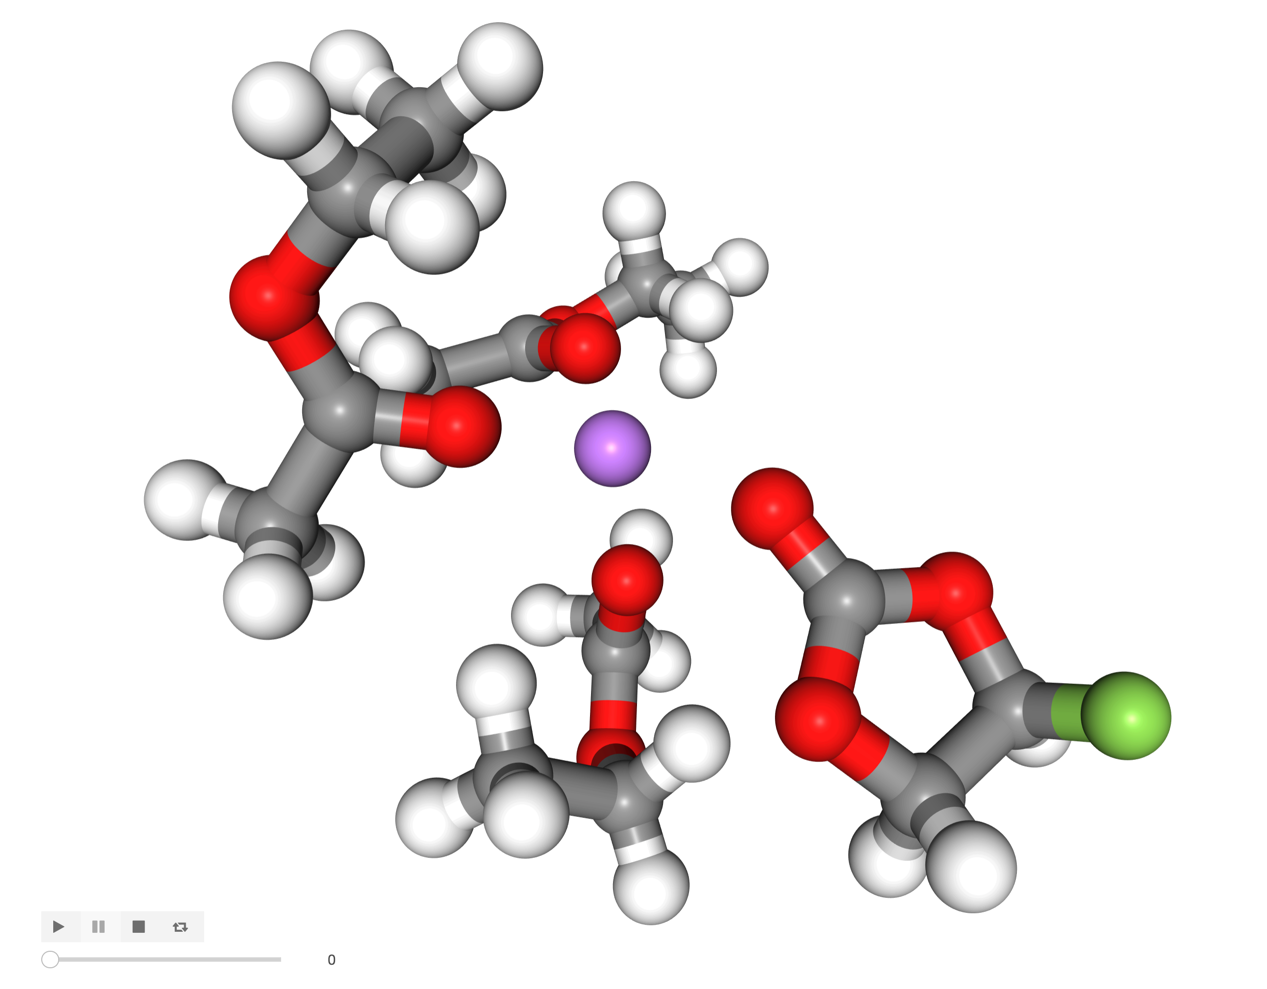

In [15]:
Image('images/shell.png', width=600)

Easy! Now we can save the visualization or explore further.

There appears to be an uncoordinated molecule to one side of our Li ion, lets investigate with the `closest_n_mol` selection function.

In [12]:
u.trajectory[0]
shell_5 = solute.closest_n_mol(solute_atom_ix=6943, n_mol=5)

In [13]:
visualize(shell_5)

NGLWidget(max_frame=9)

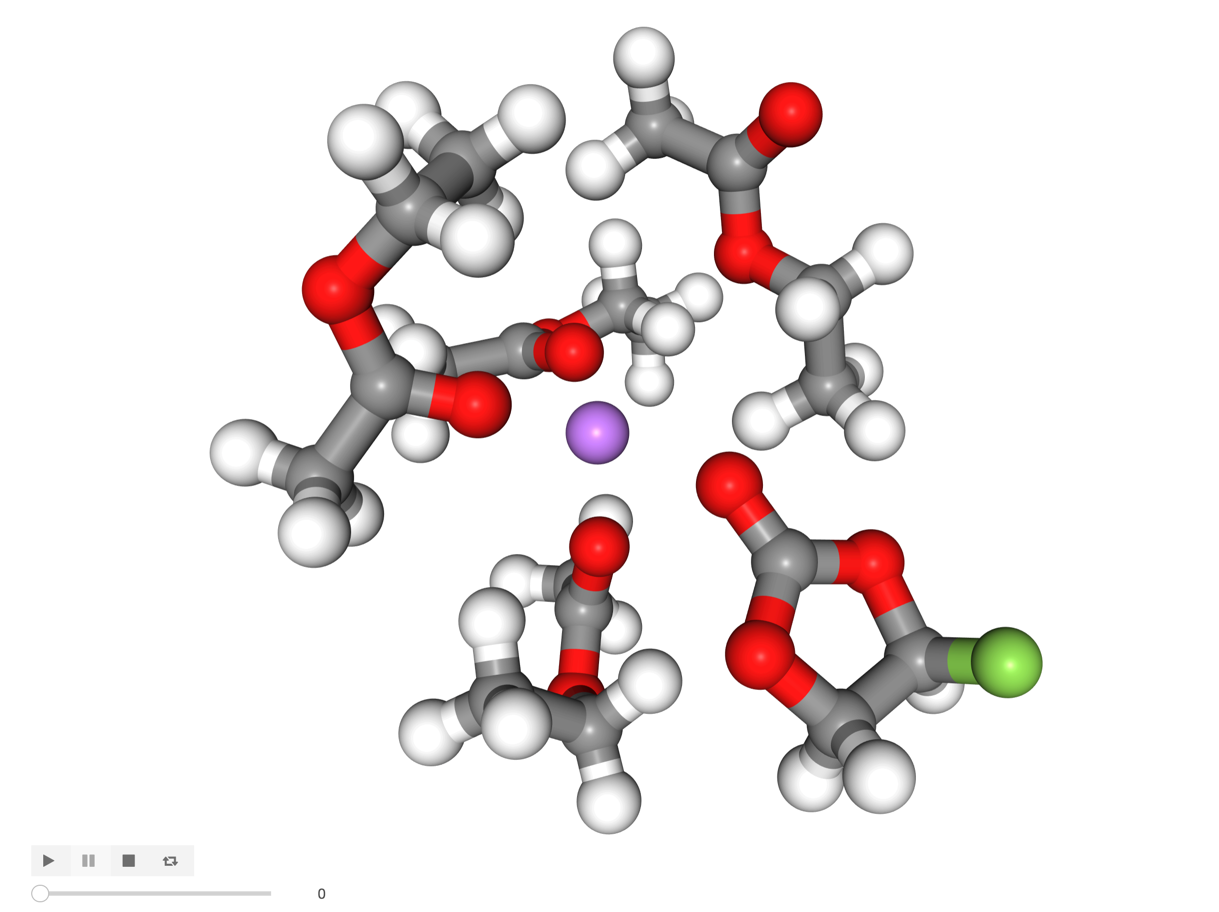

In [16]:
Image('images/shell_5.png', width=600)

An uncoordinated EA molecule is filling that space! It's not oriented correctly to coordinate with its carbonyl oxygen.

We'll stop there, but hopefully this provides a taste of what interactive visualization can look like!